In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time as time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Import

In [5]:
pd.set_option('display.max_columns', None)
train = pd.read_csv("data/train.csv", index_col="id")
train.head(5)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


### One-hot and pre-process

In [6]:
Categorical = ["Marital status", 
               "Application mode", 
               "Application order", 
               "Course", 
               "Previous qualification", 
               "Nacionality", 
               "Mother's qualification", 
               "Father's qualification", 
               "Mother's occupation", 
               "Father's occupation"]
Boolean = ["Daytime/evening attendance", 
           "Displaced", 
           "Educational special needs", 
           "Debtor", 
           "Tuition fees up to date", 
           "Gender", 
           "Scholarship holder", 
           "International" ]
Continuous = ["Previous qualification (grade)", 
              "Admission grade", 
              "Age at enrollment", 
              "Curricular units 1st sem (credited)", 
              "Curricular units 1st sem (enrolled)", 
              "Curricular units 1st sem (evaluations)", 
              "Curricular units 1st sem (approved)", 
              "Curricular units 1st sem (grade)", 
              "Curricular units 1st sem (without evaluations)",
              "Curricular units 2nd sem (credited)", 
              "Curricular units 2nd sem (enrolled)", 
              "Curricular units 2nd sem (evaluations)", 
              "Curricular units 2nd sem (approved)", 
              "Curricular units 2nd sem (grade)", 
              "Curricular units 2nd sem (without evaluations)",
              "Unemployment rate",
              "Inflation rate",
              "GDP"]

In [7]:
all_vars = Continuous + Boolean + Categorical
print(len(all_vars))
print(len(list(set(all_vars))))
print(len(train.columns))

36
36
37


In [8]:
X = pd.get_dummies(train, columns=Categorical)
del X["Target"]
len(X.columns)

290

In [9]:
Y = train["Target"]
Y.head(4)

id
0    Graduate
1     Dropout
2     Dropout
3    Enrolled
Name: Target, dtype: object

In [10]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
X[Continuous] = scaler.fit_transform(X[Continuous])

### The model

In [87]:
def my_model(X, Y, iters=100, random_state=1):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state) 

    # Initialize and train the logistic regression model
    model = LogisticRegression(solver='lbfgs', max_iter=iters)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    end_time = time.time()
    return accuracy, model, end_time - start_time

In [88]:
accuracy, model, run_time = my_model(X, Y)
print(round(accuracy, 4), run_time)

0.821 4.917194366455078


#### Model accuracy as a stochast over the sample space of train-test splits

In [91]:
accuracies = []
for i in range(500):
    accuracy, model, run_time = my_model(X, Y, iters=100, random_state=i)
    accuracies.append(accuracy)

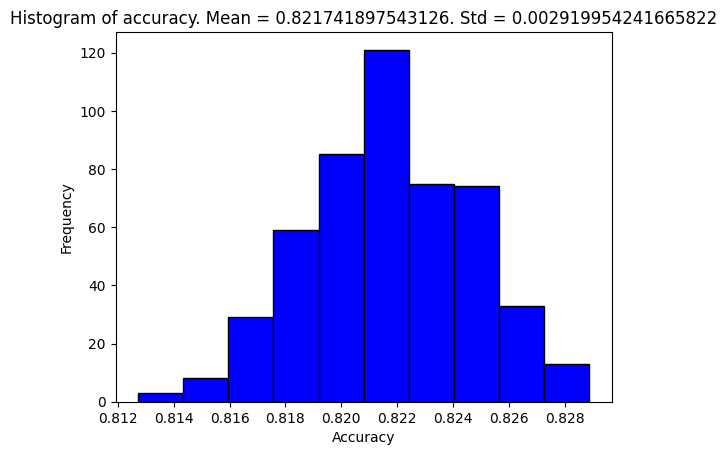

In [92]:
plt.hist(accuracies, bins=10, color='blue', edgecolor='black')
plt.title(f'Histogram of accuracy. Mean = {np.mean(accuracies)}. Std = {np.std(accuracies)}')
plt.xlabel("Accuracy")
plt.ylabel('Frequency')
plt.show()

In [12]:
def std_binom_distr(m, p):
    return np.sqrt(m * p * (1-p))

m = 0.2 * len(X)
print(m)


15303.6


### Looking at weights

In [25]:
# Get the model coefficients
coefficients = model.coef_

# Create a DataFrame to display the weights
coefficients_df = pd.DataFrame(coefficients, columns=X.columns, index=model.classes_)

coefficients_df

,Daytime/evening attendance,Previous qualification (grade),Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Marital status_1,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_1,Application mode_2,Application mode_3,Application mode_4,Application mode_5,Application mode_7,Application mode_9,Application mode_10,Application mode_12,Application mode_15,Application mode_16,Application mode_17,Application mode_18,Application mode_26,Application mode_27,Application mode_35,Application mode_39,Application mode_42,Application mode_43,Application mode_44,Application mode_51,Application mode_53,Application order_0,Application order_1,Application order_2,Application order_3,Application order_4,Application order_5,Application order_6,Application order_9,Course_33,Course_39,Course_171,Course_979,Course_8014,Course_9003,Course_9070,Course_9085,Course_9119,Course_9130,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991,Previous qualification_1,Previous qualification_2,Previous qualification_3,Previous qualification_4,Previous qualification_5,Previous qualification_6,Previous qualification_9,Previous qualification_10,Previous qualification_11,Previous qualification_12,Previous qualification_14,Previous qualification_15,Previous qualification_17,Previous qualification_19,Previous qualification_36,Previous qualification_37,Previous qualification_38,Previous qualification_39,Previous qualification_40,Previous qualification_42,Previous qualification_43,Nacionality_1,Nacionality_2,Nacionality_6,Nacionality_11,Nacionality_17,Nacionality_21,Nacionality_22,Nacionality_24,Nacionality_25,Nacionality_26,Nacionality_32,Nacionality_41,Nacionality_62,Nacionality_100,Nacionality_101,Nacionality_103,Nacionality_105,Nacionality_109,Mother's qualification_1,Mother's qualification_2,Mother's qualification_3,Mother's qualification_4,Mother's qualification_5,Mother's qualification_6,Mother's qualification_7,Mother's qualification_8,Mother's qualification_9,Mother's qualification_10,Mother's qualification_11,Mother's qualification_12,Mother's qualification_14,Mother's qualification_15,Mother's qualification_18,Mother's qualification_19,Mother's qualification_22,Mother's qualification_26,Mother's qualification_27,Mother's qualification_28,Mother's qualification_29,Mother's qualification_30,Mother's qualification_31,Mother's qualification_33,Mother's qualification_34,Mother's qualification_35,Mother's qualification_36,Mother's qualification_37,Mother's qualification_38,Mother's qualification_39,Mother's qualification_40,Mother's qualification_41,Mother's qualification_42,Mother's qualification_43,Mother's qualification_44,Father's qualification_1,Father's qualification_2,Father's qualification_3,Father's qualification_4,Father's qualification_5,Father's qualification_6,Father's qualification_7,Father's qualification_9,Father's qualification_10,Father's qualification_11,Father's qualification_12,Father's qualification_13,Father's qualification_14,Father's qualification_15,Father's qualification_18,Father's qualification_19,Father's qualification_20,Father's qualification_21,Father's qualification_22,Father's qualification_23,Father's qualification_24,Father's qualification_25,Father's qualification_26,Father's qualification_27,Father's qualification_29,Father's qualification_30,Father's qua

In [26]:
# Display the highest weights per variable
highest_weights = coefficients_df.abs().sum().nlargest(20)
highest_weights

Curricular units 2nd sem (approved)       21.429341
Curricular units 1st sem (approved)       12.334828
Curricular units 1st sem (evaluations)     7.501189
Curricular units 2nd sem (evaluations)     6.561616
Curricular units 2nd sem (enrolled)        6.076764
Curricular units 1st sem (credited)        5.670129
Curricular units 1st sem (enrolled)        5.587747
Curricular units 2nd sem (credited)        5.009778
Course_171                                 4.012318
Tuition fees up to date                    3.842637
Curricular units 2nd sem (grade)           3.520556
Curricular units 1st sem (grade)           2.312474
Father's occupation_90                     1.816971
Nacionality_1                              1.792480
Course_9853                                1.712452
Course_9119                                1.613459
Age at enrollment                          1.562522
Mother's occupation_0                      1.517799
Father's occupation_163                    1.430899
Mother's occ

In [27]:
low_weights = coefficients_df.abs().sum()
low_weights[low_weights < 0.01]

Application mode_9           0.000000
Application mode_12          0.000000
Application mode_26          0.000000
Course_39                    0.001213
Previous qualification_14    0.003366
Previous qualification_17    0.005061
Previous qualification_36    0.001388
Nacionality_32               0.002781
Mother's qualification_27    0.000000
Mother's qualification_28    0.001193
Mother's qualification_33    0.000000
Mother's qualification_44    0.001489
Father's qualification_13    0.002085
Father's qualification_15    0.003281
Father's qualification_23    0.002121
Father's qualification_25    0.000000
Father's qualification_27    0.005248
Father's qualification_33    0.002711
Mother's occupation_101      0.003926
Mother's occupation_124      0.000000
Father's occupation_12       0.003983
Father's occupation_39       0.008076
Father's occupation_96       0.000000
Father's occupation_134      0.004331
Father's occupation_161      0.009590
Father's occupation_191      0.000000
dtype: float

In [28]:
df = coefficients_df.abs().sum().reset_index()
df["index"] = df["index"].apply(lambda string: string.split("_")[0])
# Grouping by the base feature name and summing
grouped_df = df.groupby("index").sum()

# Renaming the columns
grouped_df.columns = ['Sum_of_Absolute_Weights']
grouped_df.sort_values("Sum_of_Absolute_Weights", ascending=False)

,Sum_of_Absolute_Weights
index,
Curricular units 2nd sem (approved),21.429341
Father's occupation,19.082267
Mother's occupation,16.678414
Course,16.121563
Father's qualification,12.554364
Curricular units 1st sem (approved),12.334828
Mother's qualification,10.901061
Previous qualification,9.099415
Nacionality,8.450150


### Removing data

In [43]:
grouped_df.sort_values("Sum_of_Absolute_Weights", ascending=True).head(8)

,Sum_of_Absolute_Weights
index,
GDP,0.156299
Inflation rate,0.167567
Displaced,0.330475
Educational special needs,0.373848
Curricular units 1st sem (without evaluations),0.386466
Gender,0.569360
International,0.776586
Previous qualification (grade),0.871835


In [68]:
insignificant_columns=["GDP", "Inflation rate", "Displaced", "Educational special needs"]

accuracy, model = my_model(X.drop(columns=insignificant_columns), Y, random_state =17)
round(accuracy, 4)

0.8204